In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

In [4]:
img_filepath = "/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images"
csv_filepath = "/content/drive/MyDrive/BTT Skinterest 2A/Dataset/SCIN Working Merged Spreadsheet.csv"

In [7]:
# Note: Add the shared folder as a shortcut to MyDrive for this code cell to work.
csv_df = pd.read_csv(csv_filepath)
csv_df.head()

case_id source release  year     age_group          sex_at_birth  \
0 -1.262950e+18   SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
1 -1.489550e+18   SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
2 -1.492320e+18   SCIN   1.0.0  2023  AGE_18_TO_29                FEMALE   
3 -1.580900e+17   SCIN   1.0.0  2023  AGE_18_TO_29                FEMALE   
4 -1.887630e+18   SCIN   1.0.0  2023  AGE_30_TO_39                  MALE   

  fitzpatrick_skin_type dermatologist_fitzpatrick_skin_type_label_1  \
0                   NaN                                        FST3   
1                   NaN                                        FST2   
2       NONE_IDENTIFIED                                        FST2   
3                  FST3                                        FST3   
4                  FST3                                        FST2   

  dermatologist_fitzpatrick_skin_type_label_2  \
0                                           0   
1                                           0   
2                                        FST2   
3                                           0   
4                                           0   

  dermatologist_fitzpatrick_skin_type_label_3  ...         related_category  \
0                                           0  ...                      NaN   
1                                           0  ...                      NaN   
2                                        FST2  ...            LOOKS_HEALTHY   
3                                           0  ...                     RASH   
4                                           0  ...  OTHER_ISSUE_DESCRIPTION   

   condition_duration                             image_1_path  \
0                 NaN  dataset/images/-5949315841433628424.png   
1                 NaN    dataset/images/325464533153467313.png   
2   ONE_TO_FOUR_WEEKS  dataset/images/-6837240536182868524.png   
3   ONE_TO_FOUR_WEEKS   dataset/images/2983323875335943836.png   
4  LESS_THAN_ONE_WEEK   dataset/images/3104801012387799539.png   

                              image_2_path  \
0  dataset/images/-8183947049312687778.png   
1                                      NaN   
2   dataset/images/6395257111195214043.png   
3                                      NaN   
4   dataset/images/8660513260658813359.png   

                             image_3_path image_1_shot_type image_2_shot_type  \
0  dataset/images/4923188439600899486.png       AT_DISTANCE          CLOSE_UP   
1                                     NaN          CLOSE_UP               NaN   
2  dataset/images/7877276387406078156.png       AT_DISTANCE          CLOSE_UP   
3                                     NaN          CLOSE_UP               NaN   
4                                     NaN          CLOSE_UP       AT_AN_ANGLE   

  image_3_shot_type                      combined_race  \
0       AT_AN_ANGLE                                NaN   
1               NaN                                NaN   
2       AT_AN_ANGLE  HISPANIC_LATINO_OR_SPANISH_ORIGIN   
3               NaN                              WHITE   
4               NaN                              WHITE   

   race_ethnicity_two_or_more_after_mitigation  
0                                          NaN  
1                                          NaN  
2                                          NaN  
3                                          NaN  
4                                          NaN  

[5 rows x 64 columns]

# Data Analysis and Data Cleaning

In [8]:
# count all duplicates
dup_count = csv_df.duplicated().sum()
print(f"Number of fully duplicate rows: {dup_count}")
dup_rows = csv_df[csv_df.duplicated(keep=False)]
print(dup_rows)

Number of fully duplicate rows: 0
Empty DataFrame
Columns: [case_id, source, release, year, age_group, sex_at_birth, fitzpatrick_skin_type, dermatologist_fitzpatrick_skin_type_label_1, dermatologist_fitzpatrick_skin_type_label_2, dermatologist_fitzpatrick_skin_type_label_3, monk_skin_tone_label_india, monk_skin_tone_label_us, dermatologist_skin_condition_on_label_name, dermatologist_skin_condition_confidence, race_ethnicity_american_indian_or_alaska_native, race_ethnicity_asian, race_ethnicity_black_or_african_american, race_ethnicity_hispanic_latino_or_spanish_origin, race_ethnicity_middle_eastern_or_north_african, race_ethnicity_native_hawaiian_or_pacific_islander, race_ethnicity_white, race_ethnicity_other_race, race_ethnicity_prefer_not_to_answer, textures_raised_or_bumpy, textures_flat, textures_rough_or_flaky, textures_fluid_filled, body_parts_head_or_neck, body_parts_arm, body_parts_palm, body_parts_back_of_hand, body_parts_torso_front, body_parts_torso_back, body_parts_genitali

In [9]:
image_cols = ["image_1_path","image_2_path","image_3_path"]

all_files = []

for col in image_cols:
    # take values from this column, drop blanks/NaN,
    # convert each path to just the filename (e.g. "img1.jpg")
    col_files = csv_df[col].dropna().map(lambda x: Path(str(x)).name)
    all_files.extend(col_files)

# count how many times each filename appears across ALL columns/rows
counts = Counter(all_files)

# keep only those filenames that appear more than once (duplicates)
dups = {k:v for k,v in counts.items() if v > 1}
print(f"Duplicate filenames: {len(dups)}")

# show up to the first 15 duplicate filenames and how many times each appears
for k,v in list(dups.items())[:15]:
    print(f"{k} → {v} times")


Duplicate filenames: 0


In [10]:
# build a mapping of filename -> list of (row_index, case_id, column)
rows = []
for i, row in csv_df.iterrows():
    for col in image_cols:
        val = row[col]
        if pd.notna(val) and str(val).strip():
            rows.append({
                "filename": Path(str(val)).name,
                "row_index": i,
                "case_id": row["case_id"],
                "column": col
            })

img_map = pd.DataFrame(rows)

# count in how many different rows each filename is used
dup_across_rows = (
    img_map.groupby("filename")["row_index"]
    .nunique()
    .reset_index(name="unique_rows")
    .query("unique_rows > 1")
)

print("Filenames used in more than one row:", len(dup_across_rows))
display(dup_across_rows.head(20))


Filenames used in more than one row: 0


Empty DataFrame
Columns: [filename, unique_rows]
Index: []

In [11]:
# gather all filenames actually on disk
disk_files = {p.name for p in Path(img_filepath).rglob("*") if p.is_file()}

for col in image_cols:
    col_files = csv_df[col].dropna().map(lambda x: Path(str(x)).name)
    missing = sorted(set(col_files) - disk_files)
    print(f"{col}: {len(missing)} missing")
    if missing:
        print(missing[:10])  # preview first 10 missing filenames


image_1_path: 235 missing
['-8555840247489065545.png', '-8579367048811032343.png', '-8594260406533869498.png', '-8622301865890936410.png', '-862558295135857219.png', '-8653997701010841176.png', '-8657936158769470647.png', '-8668488196925068035.png', '-8687142521108777184.png', '-870319501963618397.png']
image_2_path: 323 missing
['-8539116180751237612.png', '-8541325890788453938.png', '-8604333316388588792.png', '-8678220100544476540.png', '-8682618672042721592.png', '-8687750677002784717.png', '-8696744820413574401.png', '-8745726265111908053.png', '-8755999729037851117.png', '-8769950017377673948.png']
image_3_path: 362 missing
['-8591174633182809752.png', '-8715046487528210051.png', '-8723427709388330837.png', '-8753984834834986680.png', '-8811309900087453061.png', '-8857891249412069725.png', '-8970062608215251005.png', '-9005628762171642786.png', '-9041288694268048673.png', '-9064705102210026712.png']


In [33]:
# Check columns of interest for duplicated values
dup_image1 = csv_df.duplicated(subset=["image_1_path"]).sum()
print(dup_image1)
# 0 duplicates in image path 1 (no missing images in image path 1 column)

# Value counts filters out the NaN values.
image_2_dup_counts = csv_df['image_2_path'].value_counts()
image_2_dup_only = image_2_dup_counts[image_2_dup_counts > 1]
print(len(image_2_dup_only))

# Value counts filters out the NaN values.
image_3_dup_counts = csv_df['image_3_path'].value_counts()
image_3_dup_only = image_3_dup_counts[image_3_dup_counts > 1]
print(len(image_3_dup_only))

dup_caseid = csv_df.duplicated(subset=["case_id"]).sum()
print(dup_caseid)

# No duplicates showing from checking duplicated values like same case_ids and image paths.

0
0
0
0


### **Image Duplicate Detection using Python Library: ImageDedup** <br>
https://github.com/idealo/imagededup

In [ ]:
# Find duplicates using python library ImageDedup
!pip install imagededup

In [59]:
from imagededup.methods import PHash
from pathlib import Path
# PHash (Perceptual hash for images) imagededup method

# The directory containing dataset images
image_dir = img_filepath

# Create a PHash object
phasher = PHash()

# Find duplicates
# max_distance_threshold is used to find matches depending on the value from 0 to 64 (0 is exact duplicate match)
duplicates = phasher.find_duplicates(image_dir=image_dir, max_distance_threshold=10)

# Print the duplicate groups
for key, value in duplicates.items():
    if value: # Only print if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")

2025-09-08 21:11:40,747: INFO Start: Calculating hashes...
INFO:imagededup.methods.hashing:Start: Calculating hashes...
100%|██████████| 770/770 [00:22<00:00, 34.67it/s]
2025-09-08 21:12:03,062: INFO End: Calculating hashes!
INFO:imagededup.methods.hashing:End: Calculating hashes!
2025-09-08 21:12:03,064: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-09-08 21:12:03,066: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 770/770 [00:00<00:00, 2342.69it/s]
2025-09-08 21:12:03,466: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-09-08 21:12:03,468: INFO End: Evaluating hamming distances for getting duplicates
INF

Duplicates for -3495979407017051117.png: ['-6701195192556380.png', '-4745490554832973962.png']
Duplicates for -4861580984570611969.png: ['-8049340894007427923.png']
Duplicates for -4745490554832973962.png: ['-3495979407017051117.png', '-6701195192556380.png']
Duplicates for -7141594063372177636.png: ['-8200043395306173259.png']
Duplicates for -6701195192556380.png: ['-3495979407017051117.png', '-4745490554832973962.png']
Duplicates for -8049340894007427923.png: ['-4861580984570611969.png']
Duplicates for -8200043395306173259.png: ['-7141594063372177636.png']


Duplicates for -3495979407017051117.png: ['-6701195192556380.png', '-4745490554832973962.png']


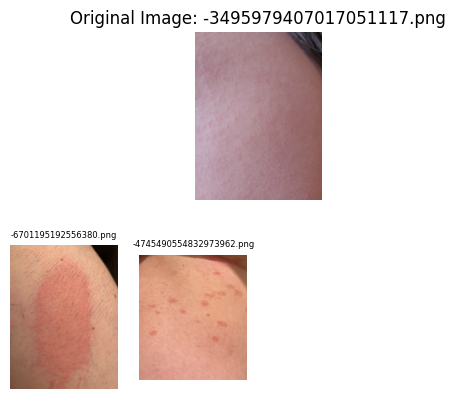

 
Duplicates for -4861580984570611969.png: ['-8049340894007427923.png']


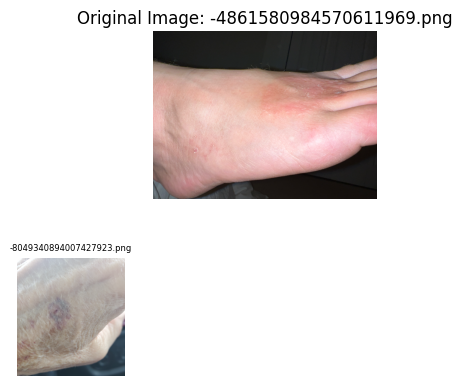

 
Duplicates for -4745490554832973962.png: ['-3495979407017051117.png', '-6701195192556380.png']


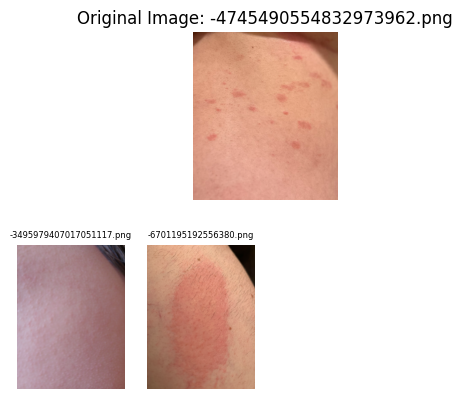

 
Duplicates for -7141594063372177636.png: ['-8200043395306173259.png']


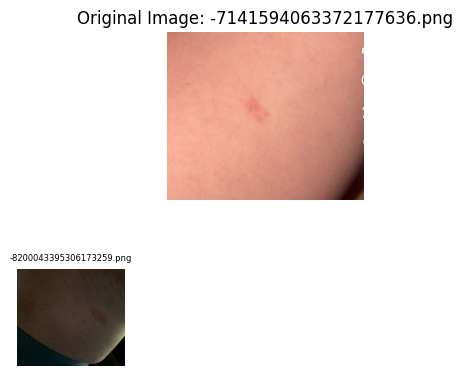

 
Duplicates for -6701195192556380.png: ['-3495979407017051117.png', '-4745490554832973962.png']


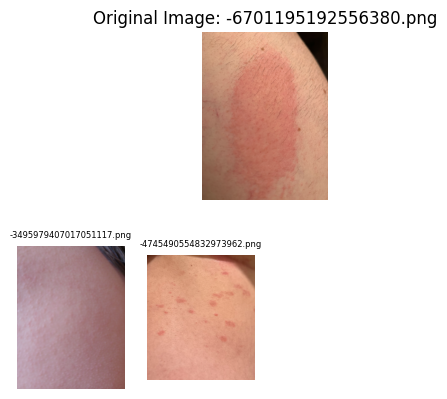

 
Duplicates for -8049340894007427923.png: ['-4861580984570611969.png']


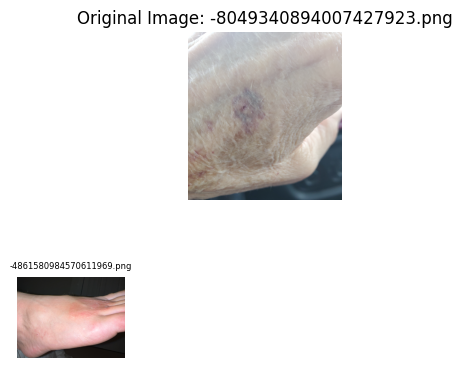

 
Duplicates for -8200043395306173259.png: ['-7141594063372177636.png']


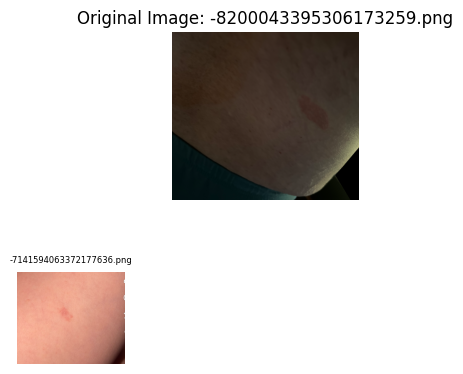

In [62]:
from imagededup.utils import plot_duplicates
# Plot/show the images stored in duplicates
for key, value in duplicates.items():
    if value: # Only plot if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")
        plot_duplicates(image_dir=img_filepath, duplicate_map=duplicates, filename=key)
        print(" ")

Note from PHash experiment: PHash did not return close duplicates. A max distance threshold of 10 returned some images, even though they were not close duplicates.

However, a max distance threshold of 5 (decreasing the threshold value) did not return any duplicate images. As we try to identify close duplicate images (eventually to the 0 value), this method shows us there are no exact duplicate images.

Let's try using the Convolutional Neural Network method of ImageDedup

In [63]:
# Convolutional Neural Network method from ImageDedup for identifying duplicate images.
from imagededup.methods import CNN
image_dir = img_filepath
cnn = CNN()
duplicates = cnn.find_duplicates(image_dir=image_dir, min_similarity_threshold=0.9)
# Print the duplicate groups
for key, value in duplicates.items():
    if value: # Only print if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")

2025-09-08 21:21:36,510: INFO Device set to cuda ..
INFO:imagededup.methods.cnn:Device set to cuda ..
2025-09-08 21:21:36,520: INFO Initialized: mobilenet_v3_small for feature extraction ..
INFO:imagededup.methods.cnn:Initialized: mobilenet_v3_small for feature extraction ..
2025-09-08 21:21:36,523: INFO Start: Image encoding generation
INFO:imagededup.methods.cnn:Start: Image encoding generation
2025-09-08 21:22:02,632: INFO End: Image encoding generation
INFO:imagededup.methods.cnn:End: Image encoding generation
2025-09-08 21:22:02,665: INFO Start: Calculating cosine similarities...
INFO:imagededup.methods.cnn:Start: Calculating cosine similarities...
2025-09-08 21:22:02,675: INFO End: Calculating cosine similarities.
INFO:imagededup.methods.cnn:End: Calculating cosine similarities.


Duplicates for -1144385403699610414.png: [np.str_('-3710485127899507294.png')]
Duplicates for -1379677912378977305.png: [np.str_('-6817367779721765450.png')]
Duplicates for -1678791492949621880.png: [np.str_('-2007890488191008351.png')]
Duplicates for -2007890488191008351.png: [np.str_('-1678791492949621880.png')]
Duplicates for -2360785524468890383.png: [np.str_('-6812826722344587691.png'), np.str_('-7328965896866106554.png')]
Duplicates for -284320352049367340.png: [np.str_('-7768632674370440453.png')]
Duplicates for -3710485127899507294.png: [np.str_('-1144385403699610414.png')]
Duplicates for -6812826722344587691.png: [np.str_('-2360785524468890383.png'), np.str_('-7328965896866106554.png')]
Duplicates for -6817367779721765450.png: [np.str_('-1379677912378977305.png')]
Duplicates for -6883370563107027349.png: [np.str_('-8509651194925877853.png')]
Duplicates for -7328965896866106554.png: [np.str_('-2360785524468890383.png'), np.str_('-6812826722344587691.png')]
Duplicates for -77686

Duplicates for -1144385403699610414.png: [np.str_('-3710485127899507294.png')]


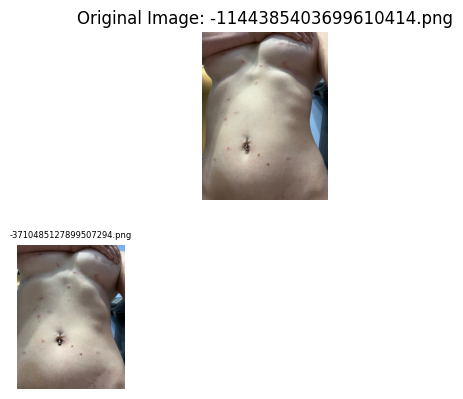

 
Duplicates for -1379677912378977305.png: [np.str_('-6817367779721765450.png')]


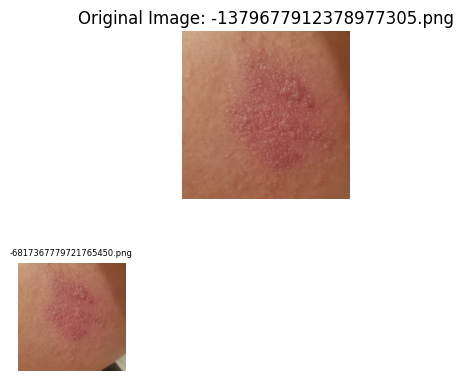

 
Duplicates for -1678791492949621880.png: [np.str_('-2007890488191008351.png')]


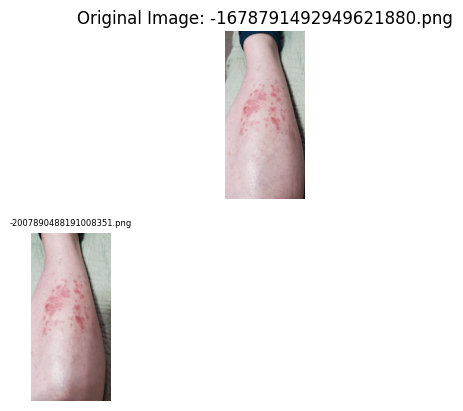

 
Duplicates for -2007890488191008351.png: [np.str_('-1678791492949621880.png')]


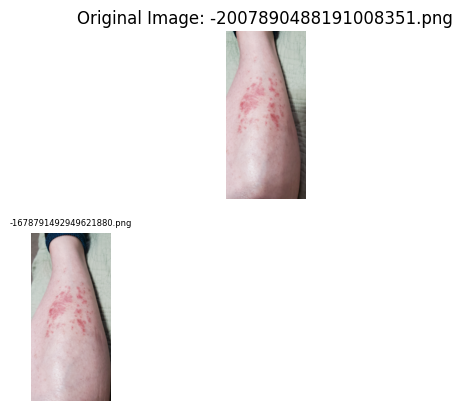

 
Duplicates for -2360785524468890383.png: [np.str_('-6812826722344587691.png'), np.str_('-7328965896866106554.png')]


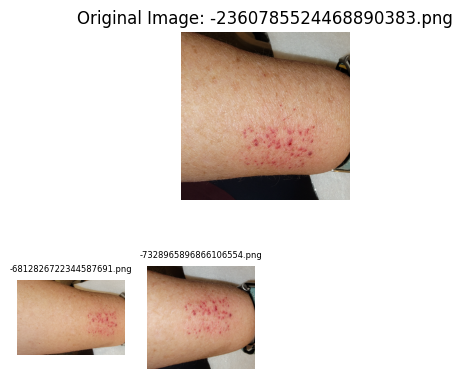

 
Duplicates for -284320352049367340.png: [np.str_('-7768632674370440453.png')]


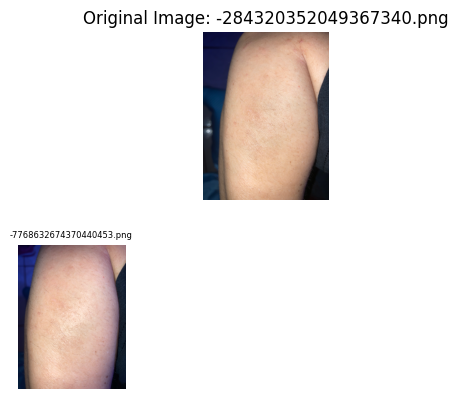

 
Duplicates for -3710485127899507294.png: [np.str_('-1144385403699610414.png')]


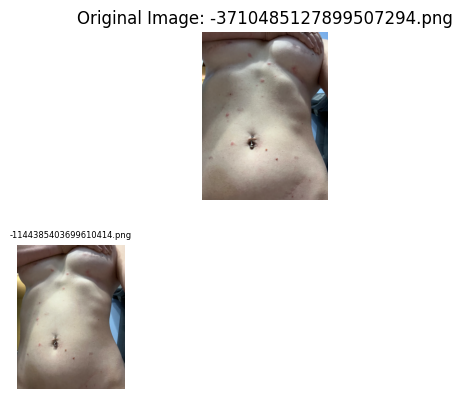

 
Duplicates for -6812826722344587691.png: [np.str_('-2360785524468890383.png'), np.str_('-7328965896866106554.png')]


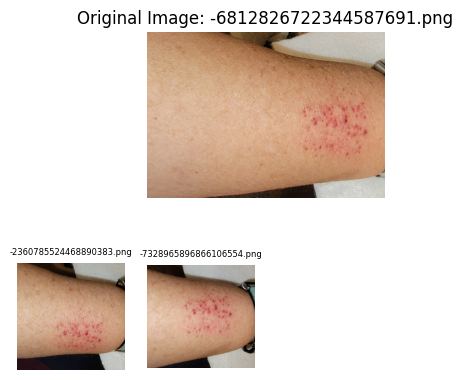

 
Duplicates for -6817367779721765450.png: [np.str_('-1379677912378977305.png')]


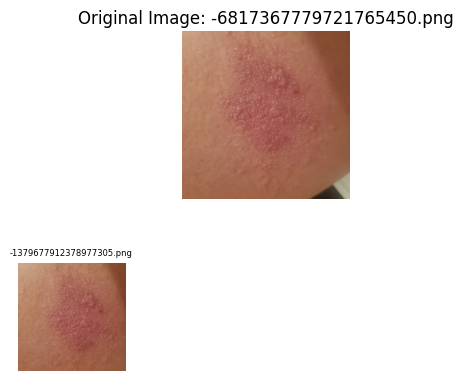

 
Duplicates for -6883370563107027349.png: [np.str_('-8509651194925877853.png')]


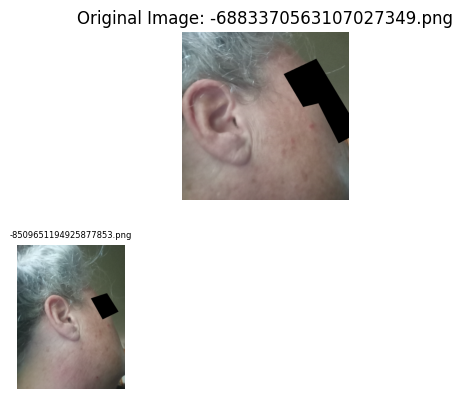

 
Duplicates for -7328965896866106554.png: [np.str_('-2360785524468890383.png'), np.str_('-6812826722344587691.png')]


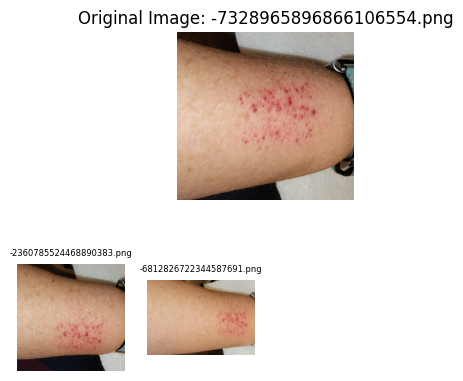

 
Duplicates for -7768632674370440453.png: [np.str_('-284320352049367340.png')]


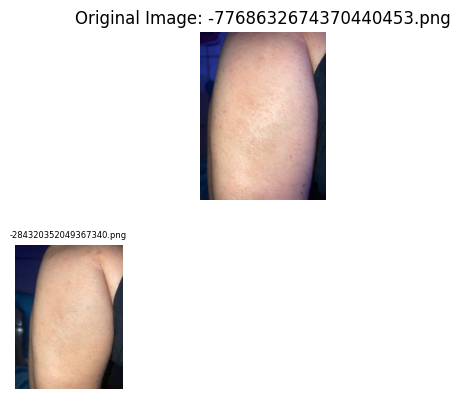

 
Duplicates for -7902413542705171594.png: [np.str_('-8295744562871956484.png')]


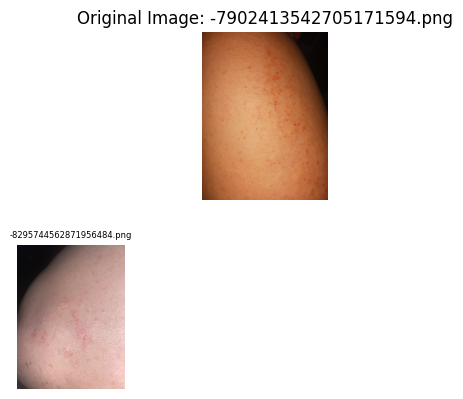

 
Duplicates for -8295744562871956484.png: [np.str_('-7902413542705171594.png')]


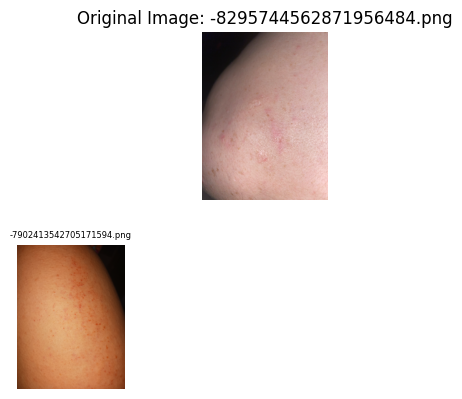

 
Duplicates for -8509651194925877853.png: [np.str_('-6883370563107027349.png')]


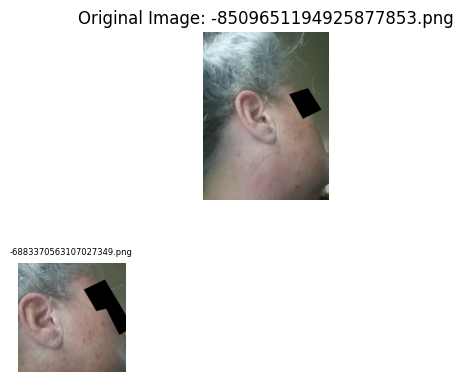

In [64]:
for key, value in duplicates.items():
    if value: # Only plot if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")
        plot_duplicates(image_dir=img_filepath, duplicate_map=duplicates, filename=key)
        print(" ")

Note from CNN experiment: CNN returned more similar / near-duplicate images compared to the PHash imagededup method. One thought for consideration is whether we want to keep or not keep similar images based on angles, lighting, perspective, cropping, etc. For example, if similar pictures have the same angle and size of skin condition, should it be kept in the dataset?

This CNN experiment/code used a minimum similarity threshold of 0.9. The highest this threshold can be is 1.0 (notice the different threshold criteria for PHash and CNN).

In [55]:
from imagededup.methods import CNN
image_dir = img_filepath
cnn = CNN()
duplicates = cnn.find_duplicates(image_dir=image_dir, min_similarity_threshold=1.0)
# Print the duplicate groups
for key, value in duplicates.items():
    if value: # Only print if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")

2025-09-08 20:53:58,148: INFO Device set to cuda ..
INFO:imagededup.methods.cnn:Device set to cuda ..
2025-09-08 20:53:58,158: INFO Initialized: mobilenet_v3_small for feature extraction ..
INFO:imagededup.methods.cnn:Initialized: mobilenet_v3_small for feature extraction ..
2025-09-08 20:53:58,162: INFO Start: Image encoding generation
INFO:imagededup.methods.cnn:Start: Image encoding generation
2025-09-08 20:54:24,727: INFO End: Image encoding generation
INFO:imagededup.methods.cnn:End: Image encoding generation
2025-09-08 20:54:24,772: INFO Start: Calculating cosine similarities...
INFO:imagededup.methods.cnn:Start: Calculating cosine similarities...
2025-09-08 20:54:24,782: INFO End: Calculating cosine similarities.
INFO:imagededup.methods.cnn:End: Calculating cosine similarities.


Doing the CNN method with min similarity threshold of 1.0 results in no duplicated images. ImageDedup for CNN method is showing there are near-duplicate images, but cannot find exact image duplicates.

### **Method 1: Pillow Library**
https://pillow.readthedocs.io/en/stable/handbook/overview.html

This script scans a folder of images and reports which files are corrupted based on whether Pillow can successfully open and fully decode them.

- Uses Pillow (PIL) to open each file.
- `img.verify()` checks the image header for validity.
- `img.load()` forces the program to fully read pixel data,
  catching cases where an image looks valid but is actually truncated or broken.
- Corrupted files are collected into a list and printed at the end.
- The original dataset is not modified.


In [12]:
!pip install pillow

**Method 1: Pillow Library**
https://pillow.readthedocs.io/en/stable/handbook/overview.html

This script scans a folder of images and reports which files are corrupted based on whether Pillow can successfully open and fully decode them.

- Uses Pillow (PIL) to open each file.
- `img.verify()` checks the image header for validity.
- `img.load()` forces the program to fully read pixel data,
  catching cases where an image looks valid but is actually truncated or broken.
- Corrupted files are collected into a list and printed at the end.
- The original dataset is not modified.


In [13]:
import os
from PIL import Image

def check_corrupted_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()   # Header check
        with Image.open(file_path) as img:
            img.load()     # Force pixel data load
        return False
    except Exception as e:
        print(f"Corrupted image: {file_path} - {e}")
        return True

def list_corrupted_images(folder_path):
    corrupted_files = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            try:
                if check_corrupted_image(file_path):
                    corrupted_files.append(file_path)
            except Exception as e:
                # Catch anything unexpected
                print(f"Error checking {file_path}: {e}")
                corrupted_files.append(file_path)
    return corrupted_files

# Example usage:
corrupted = list_corrupted_images(img_filepath)
print(f"Checked {len(os.listdir(img_filepath))} files")
print("Corrupted images:")
for f in corrupted:
    print(f)


Checked 770 files
Corrupted images:


There is nothing printed which means there are no corrupted files that exist within the dataset

### Method 2: Cleanvision library

https://github.com/cleanlab/cleanvision

This script uses the CleanVision library to automatically audit an image dataset. It scans all images in the given folder for common issues (e.g., blur, duplicates,brightness problems, resolution outliers) and produces a report.

In [14]:
!pip install cleanvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 18.5 MB/s eta 0:00:00


Reading images from /content/drive/MyDrive/BTT Skinterest 2A/Dataset/images
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/770 [00:00<?, ?it/s]

Issue checks completed. 63 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |           57 |
|  1 | odd_size         |            4 |
|  2 | low_information  |            1 |
|  3 | odd_aspect_ratio |            1 |
|  4 | dark             |            0 |
|  5 | light            |            0 |
|  6 | grayscale        |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 

---------------------- blurry images -----------------------

Number of examples with this issue: 57
Examples representing most severe instances of this issue:



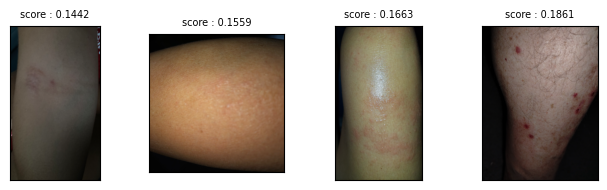

--------------------- odd_size images ----------------------

Number of examples with this issue: 4
Examples representing most severe instances of this issue:



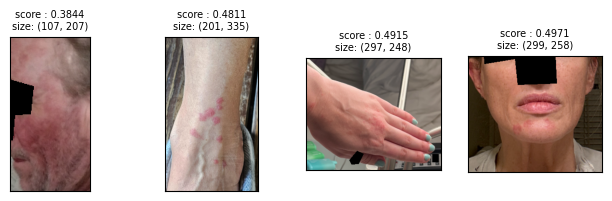

------------------ low_information images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



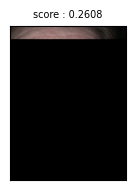

----------------- odd_aspect_ratio images ------------------

Number of examples with this issue: 1
Examples representing most severe instances of this issue:



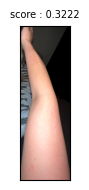

In [15]:

from cleanvision import Imagelab

# Specify path to folder containing the image files in your dataset
imagelab = Imagelab(data_path=img_filepath)

# Automatically check for a predefined list of issues within your dataset
imagelab.find_issues()

# Produce a neat report of the issues found in your dataset
imagelab.report()


In [16]:
# Filter only blurry images, sorted by blur score
blurry_images = imagelab.issues[imagelab.issues["is_blurry_issue"] == True].sort_values(
    by=["blurry_score"]
)

# Print filename + blur score
for file, row in blurry_images.iterrows():
    print(f"{file}: {row['blurry_score']}")


/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-4776585734244061924.png: 0.14420305263913935
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-5235101161732341625.png: 0.15592930286608708
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-4271531030985247738.png: 0.1662863838759342
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-6056766218809084116.png: 0.186117968999838
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-7553196319522858797.png: 0.20158145622421986
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-7902413542705171594.png: 0.20363664430216943
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-4073226241877822619.png: 0.2130890785349553
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-4754525280611243155.png: 0.22067492621233975
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-8378597063323783191.png: 0.2216427362501442
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-49978260446088946.png: 0.22199

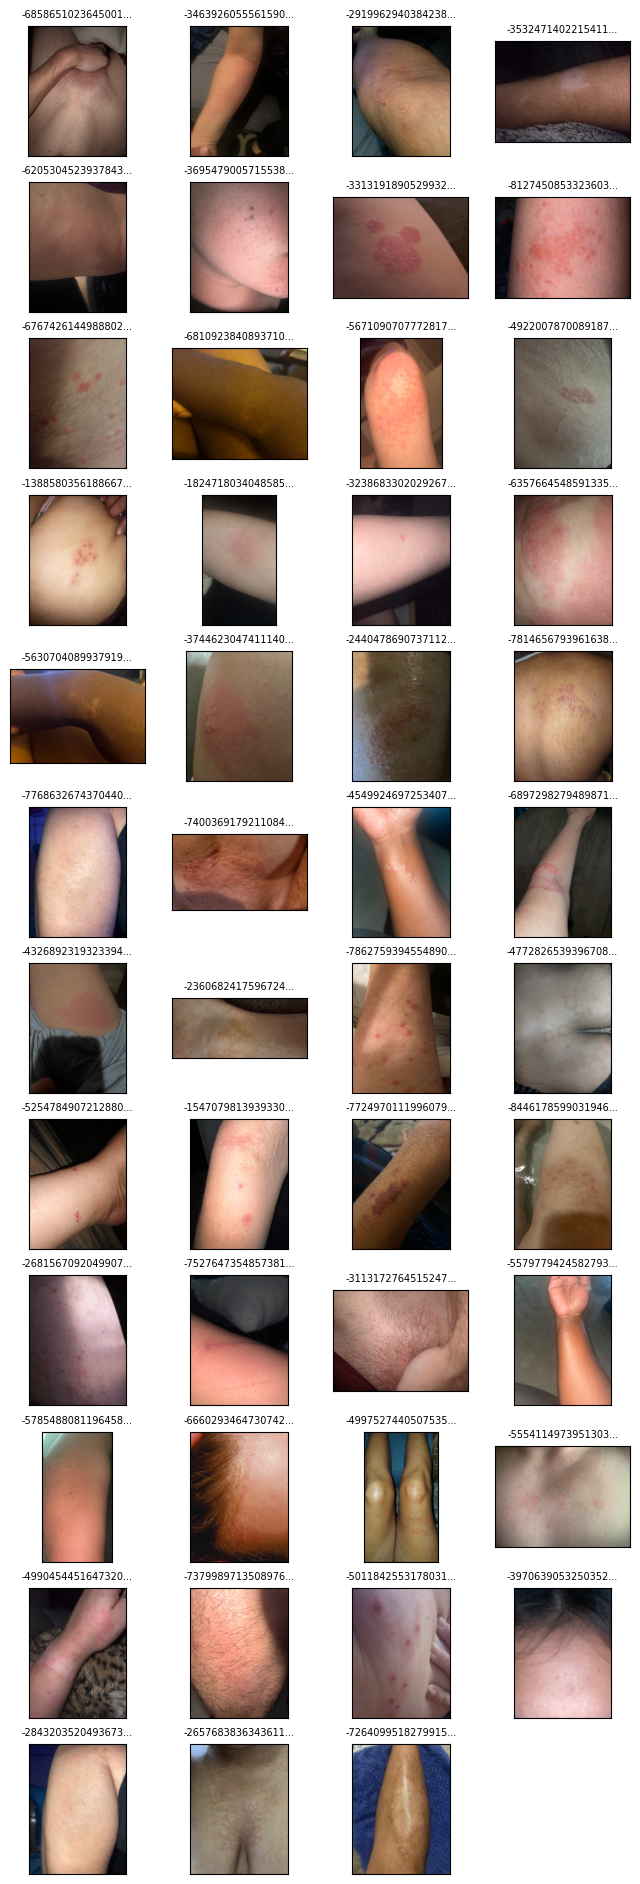

In [17]:
# Get top 10 blurry image file paths
top_blurry_files = blurry_images.index[10:].tolist()

# Visualize those images
imagelab.visualize(image_files=top_blurry_files)


Most blurry image: /content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-4776585734244061924.png with score: 0.14420305263913935


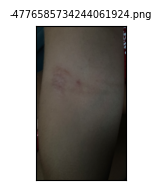

Least blurry image: /content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-7264099518279915271.png with score: 0.2878783779320334


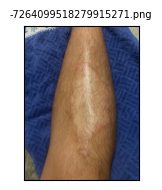

In [18]:
# Find most blurry image (lowest score)
most_blurry_file = blurry_images.index[0]  # filename
most_blurry_score = blurry_images.iloc[0]["blurry_score"]
print("Most blurry image:", most_blurry_file, "with score:", most_blurry_score)

imagelab.visualize(image_files=[most_blurry_file])  # pass as list

# Find least blurry image (lowest score among flagged)
least_blurry_file = blurry_images.index[-1]  # filename
least_blurry_score = blurry_images.iloc[-1]["blurry_score"]
print("Least blurry image:", least_blurry_file, "with score:", least_blurry_score)

imagelab.visualize(image_files=[least_blurry_file])  # pass as list


According to the analysis of our dataset, we currently have 57 blurry images, 4 odd size, 1 low_information, and 1 odd_ascpect_ratio image within our dataset.

The most problematic images we may have to remove are the blurry images, but an threshold needs to be established for these images.


### OpenCV

The Laplacian blur detection works by:

- Converting the image to grayscale.
- Applying the Laplacian operator to detect edges.
- Measuring the variance of those edge values.
- High variance → many strong edges → image is sharp.
- Low variance → weak edges → image is blurry.
- Thresholding the variance decides if the image is blurry or not.

In [19]:
import os
import cv2
from pathlib import Path

def blur_score(image):
    """
    Compute Laplacian variance (focus measure).
    Higher variance = sharper, lower = blurrier.
    """
    if image is None:
        return -1.0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    variance = lap.var()

    return variance


def scan_all_images(root_dir,
                    exts={".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}):
    results = []
    root = Path(root_dir)
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            img = cv2.imread(str(p))
            var = blur_score(img)
            results.append({"path": str(p), "variance": var})
    results.sort(key=lambda d: d["variance"])
    return results

In [20]:
results = scan_all_images(img_filepath)

print(f"Scanned {len(results)} images")
results.sort(key=lambda d: d["variance"])
for r in results:
    print(f"{r['path']}: {r['variance']}")

Scanned 770 images
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-3749637390051796787.png: 3.7719854603790566
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-3495979407017051117.png: 4.573563386001091
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-6637063938529970478.png: 5.400309783493004
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-3712172422022433576.png: 5.474964468441229
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-3678897900470319701.png: 5.542904606844357
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-7195700219000080752.png: 5.5811227493378155
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-3864405960970388084.png: 6.165520489193402
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-6198967189233641907.png: 6.311961578671118
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-1639533999116789945.png: 6.6468489945631575
/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images/-3463926055561590672.p

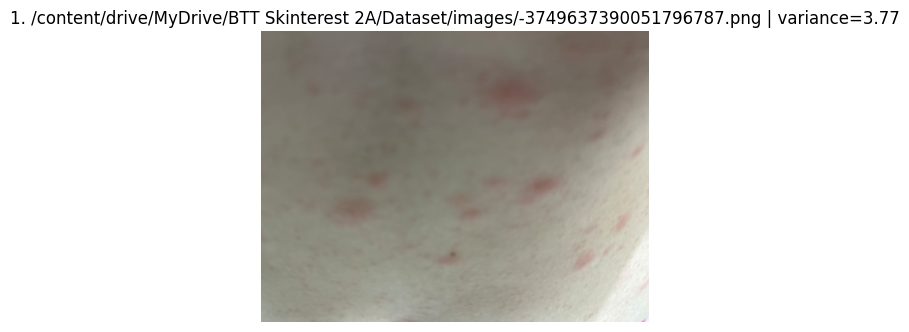

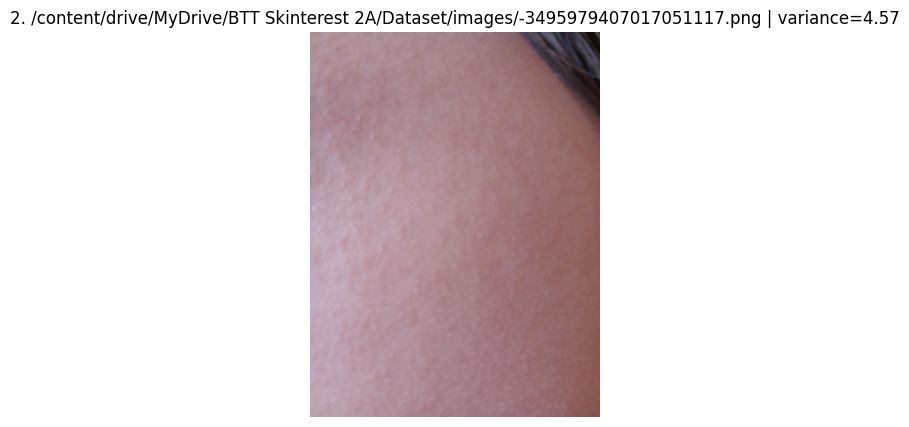

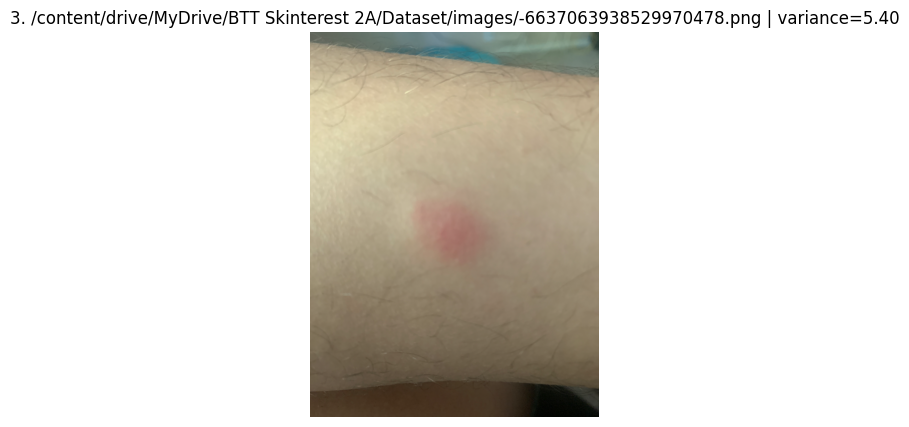

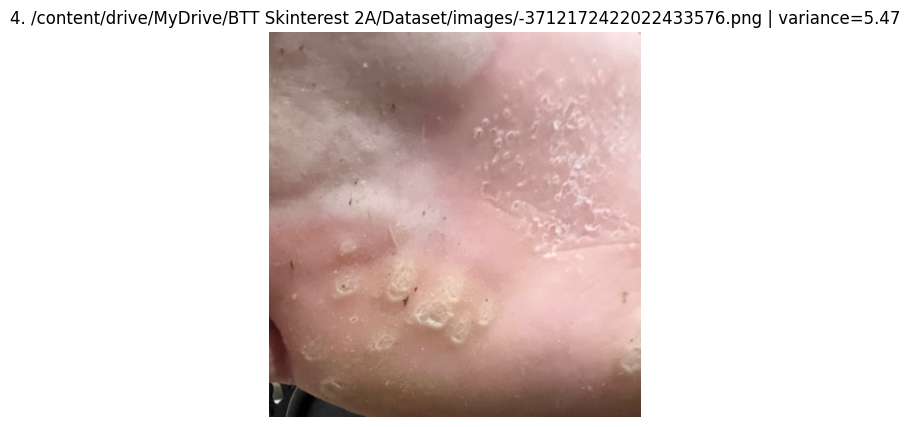

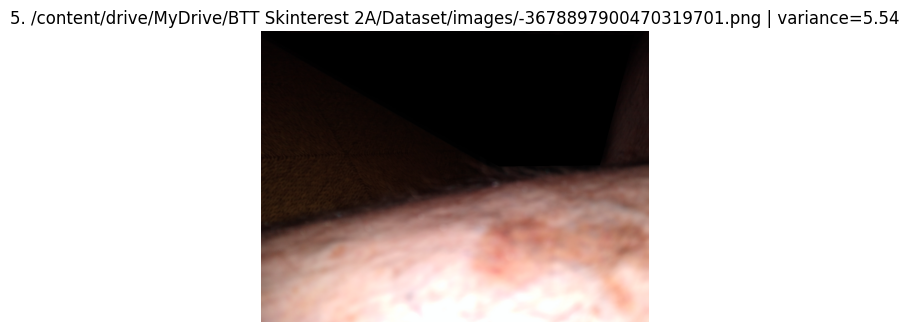

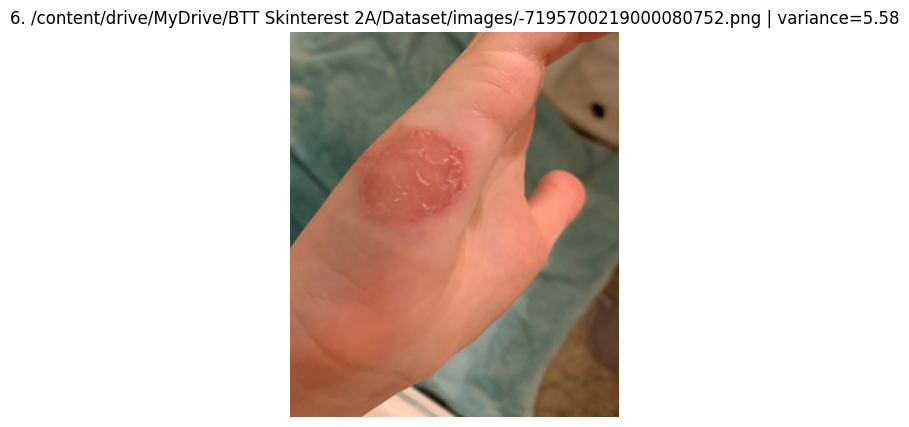

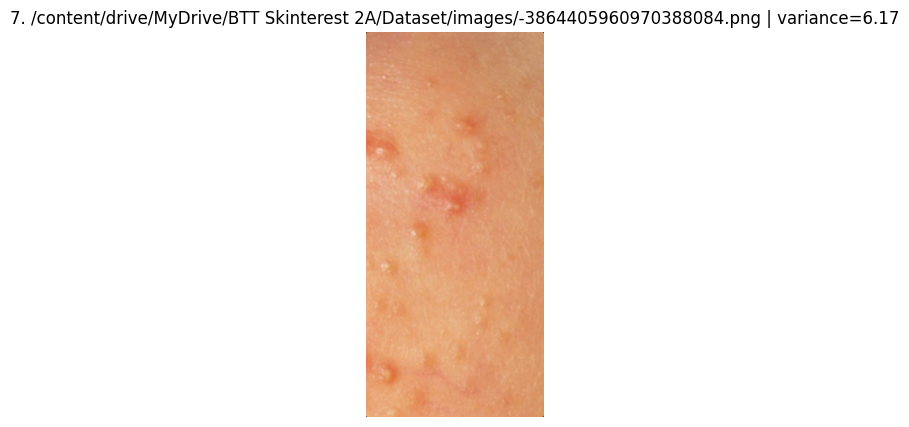

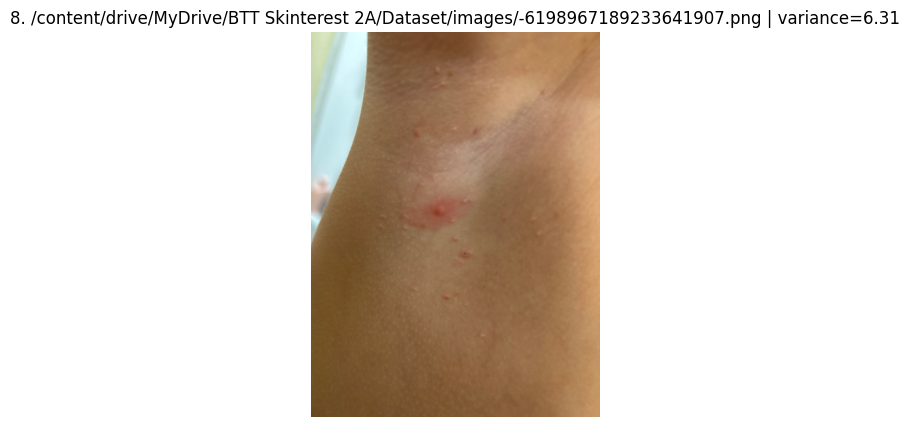

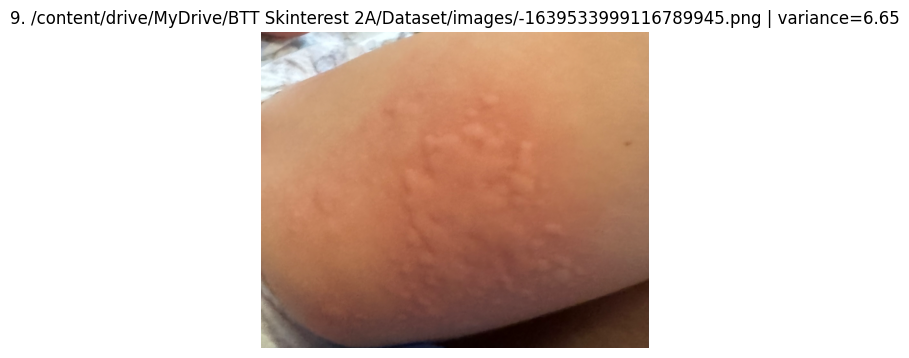

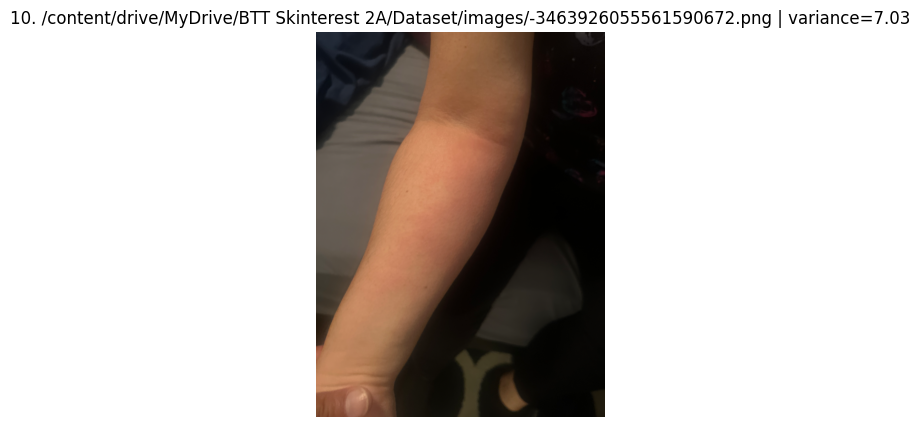

In [21]:
for i, r in enumerate(results[:10]):
    img = cv2.imread(r["path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title(f"{i+1}. {r['path']} | variance={r['variance']:.2f}")
    plt.axis("off")
    plt.show()


### Result Comparisons

Imagelab vs. OpenCV

- *Imagelab blur detection* gives an comprehensive report of the image dataset in terms of blurs, duplicates, brightness, and outliers. Their results are more nuanced and uses additional built in signals beyond edge variance, so it can flag blur that comes from poor focus, motion, or even lighting conditions that reduce detail visibility.

- *OpenCV blur detection* method uses laplacian varience and only looks at sharpness and edges to determine blur score. If edges are weak (low variance), it calls the image blurry. It does not consider lighting, exposure, or contrast. (Need to pick an threshold to determine what is blurry and what is not. One method is using mean of all images)


Pros vs. Cons
| Method                | Pros                                                                 | Cons                                                                 |
|------------------------|----------------------------------------------------------------------|----------------------------------------------------------------------|
| **OpenCV (Laplacian Variance)** | - Simple & very fast  <br> - Easy to interpret (variance = sharpness) <br> - Good at catching obvious motion/defocus blur | - Sensitive to lighting/contrast <br> - May flag smooth skin as blurry <br> - No awareness of lesion region importance |
| **Cleanvision / Imagelab**      | - Considers sharpness *and* lighting/exposure <br> - Handles subtle dermatology images better <br> - Integrates with other quality checks (odd size, brightness, etc.) | - Slower on large datasets <br> - Blur score less transparent <br> - Needs threshold tuning + manual spot checks |


According to **Quantifying acceptable artefact ranges for dermatologic classification algorithms**, general blur simulated to look like blurring caused by an object being outside the depth of field or by motion of the camera along its optical axis is the most dangerous for dermatology classification tasks. General blur makes the image appear less sharp and detailed.

To help combat this and determine which images to remove suggestion:
1. Start with Imagelab results and remove them as seen fit
2. Use OpenCV Laplacian variance as a secondary check for extreme motion blur or focus issues
3. Manual Validation

## Note:

1. need to detect for extreme lightings w/OpenCV and compare those results
2. Need to Determine which images should be cleared from data + how to clean up data file

So far:
- determine if images repeated within file rows/columns exactly (none)
- not sure what are the 15 known duplucates and missing
- only analyzed dataset for blur & sharpness

September 8, 2025 update:
- Found some images that are near-duplicates, but not exactly duplicates (slightly different angles, cropping, etc.)
